In [152]:
"""
This notebook investigates the application of 
Principal Component Analysis to K-Means Clustering 
for dimensionality reduction and visualization
"""

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

import scipy.io as sio
from PIL import Image
import math

sns.set_context('notebook')
sns.set_style('white')
#plt.style.use('fivethirtyeight')
plt.xkcd() # because why not?
np.set_printoptions(precision=3)

In [153]:
data = sio.loadmat('ex7data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [201]:
test = makeColormap()
test[0].reshape(3, 1)

array([[ 0.498],
       [ 0.788],
       [ 0.498]])

In [204]:
hello = 'rgb'
hello[0]

'h'

In [214]:
colormap = makeColormap()
colormap[0]

(0.4980392156862745, 0.788235294117647, 0.4980392156862745)

In [239]:
# Custom colormap
def makeColormap():
    colormap = list(cm.get_cmap('Accent').colors)
    colormap.extend(cm.get_cmap('Set1').colors)
    colormap.extend(cm.get_cmap('Set3').colors)
    return colormap

def plotData(X, size=(10, 6)):
    plt.figure(figsize=size)
    plt.scatter(X[:, 0], X[:, 1], c='orange', marker='o', edgecolors='k',linewidths=1)

def plotData3D(X, idx, K):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    colormap = makeColormap()
    for i in range(K):
        X_plt = X[idx == i]
        ax.scatter(X_plt[:, 0], X_plt[:, 1], X_plt[:, 2], c=colormap[i])
    
def drawLine(p1, p2, options):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], options)
    
def displayData(X, width=round(math.sqrt(X.shape[1]))):
    """Displays 2D Data in a nice grid"""
    m, n = X.shape
    height = n // width
    
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    
    pad = 1
    
    display_array = -np.ones((pad + display_rows * (height + pad), \
                            pad + display_cols * (width + pad))) 
    curr_ex = 0
    for j in range(0, display_rows):
        for i in range(0, display_cols):
            max_val = np.absolute(X[curr_ex]).max()
            row, col = np.indices((height, width))
            display_array[pad + j * (height+pad) + row, \
                          pad + i * (width+pad) + col] = \
                            X[curr_ex].reshape(height, width, order='F') / max_val
                            #np.reshape(X[curr_ex], (height, width)) / max_val
            curr_ex += 1
        if curr_ex > m:
            break
    plt.imshow(display_array, cmap='gray')

In [155]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

def pca(X):
    m = X.shape[0]
    Sigma = 1/m * (X.T @ X)
    return np.linalg.svd(Sigma)

def projectData(X, U, K):
    """Projects X onto the top K eigenvectors in U"""
    return X @ U[:, 0:K]

def recoverData(Z, U, K):
    """Approximates compressed data given projected data Z"""
    return Z @ U[:, 0:K].T

In [156]:
def initCentroids(X, K):
    m, n = X.shape
    idx = np.random.choice(m, size=K, replace=False)
    return X[idx]

def findClosestCentroids(X, centroids):
    m = X.shape[0]
    K = centroids.shape[0]
    dist = np.zeros((m, K))
    for i in range(K):
        dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)
    return np.argmin(dist, axis=1)

def computeCentroids(X, idx, K):
    idx_mat = (idx.reshape(X.shape[0], 1) == np.arange(K))
    return (idx_mat.T @ X) / np.sum(idx_mat, axis=0).reshape((K, 1))

In [157]:
def KMeans(X, centroids_init, max_iters, plot=True):
    if plot: 
        plt.figure(figsize=(10, 6))
        colormap = makeColormap()
        centroids_hist = centroids_init
    m, n = X.shape
    K = len(centroids_init)
    centroids = centroids_init

    for i in range(max_iters):
        print('Running K-Means iteration {} / {}'.format(i+1, max_iters), end='\r')
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
        
        if plot:
            centroids_hist = np.append(centroids_hist, centroids, axis=0)

    if plot:
        plotData(X, idx, K)
        # Plot Lines
        for i in range(K):
            mu = centroids_hist[i:-1:K]
            plt.plot(mu[:, 0], mu[:, 1], color=colormap[i], lw=0.5)

        plt.scatter(centroids_hist[:, 0], centroids_hist[:, 1], marker='x', color='k') 
        plt.show()
    return centroids, idx

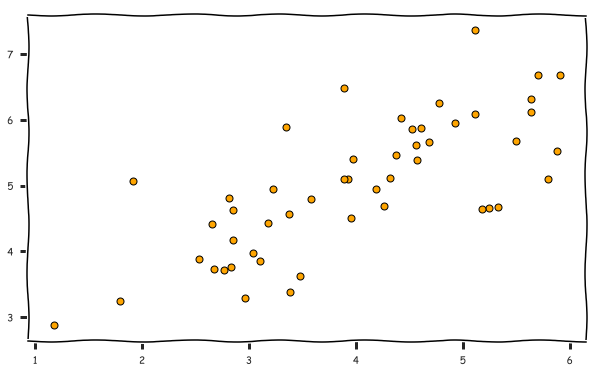

In [158]:
# Visualize dataset
X = data['X']

plotData(X)

Top Eigenvector: 
[-0.707 -0.707]


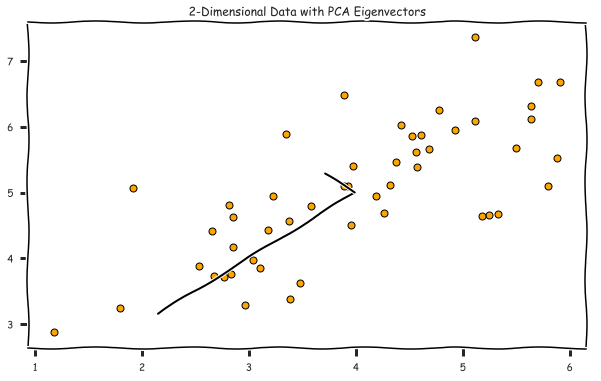

In [161]:
# Normalize features
X_norm, mu, sigma = featureNormalize(X)

# Run PCA
U, S, _ = pca(X_norm)

print('Top Eigenvector: \n{}'.format(U[:, 0]))

plotData(X)
drawLine(mu, mu + 1.5 * (S[0] * U[:, 0].T), 'k')
drawLine(mu, mu + 1.5 * (S[1] * U[:, 1].T), 'k')
plt.title('2-Dimensional Data with PCA Eigenvectors')

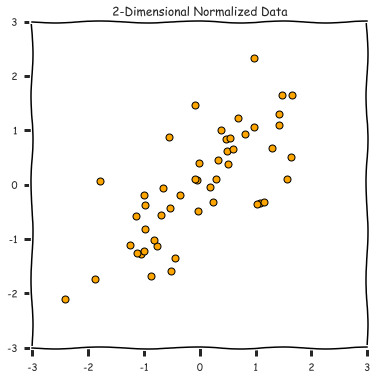

In [162]:
plotData(X_norm, size=(6,6))
plt.title('2-Dimensional Normalized Data')
plt.axis([-3, 3, -3, 3]);

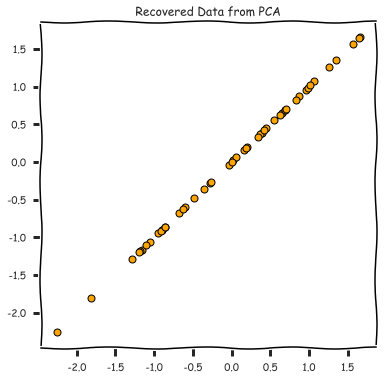

In [163]:
# Project data onto 1st dimension
K = 1
Z = projectData(X_norm, U, K)
X_rec = recoverData(Z, U, K)

plotData(X_rec, size=(6,6))
plt.title('Recovered Data from PCA')

In [164]:
# Loading and visualizing face data
data = sio.loadmat('ex7faces.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [165]:
X = data['X']

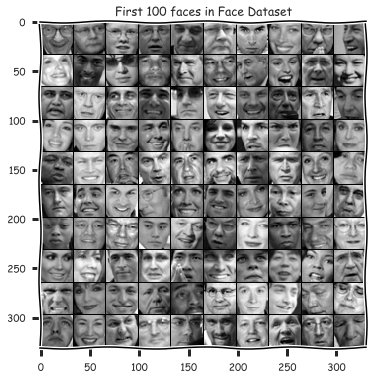

In [166]:
plt.figure(figsize=(10,6))
displayData(X[:100])
plt.title('First 100 faces in Face Dataset')

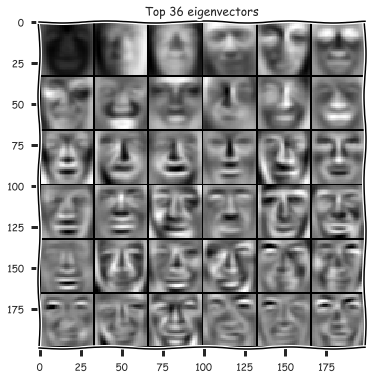

In [167]:
X_norm, mu, sigma = featureNormalize(X)
U, S, _ = pca(X_norm)

plt.figure(figsize=(10,6))
displayData(U[:, 0:36].T)
plt.title('Top 36 eigenvectors')
# These are also known as eigenfaces

The projected data has a size of (5000, 100)


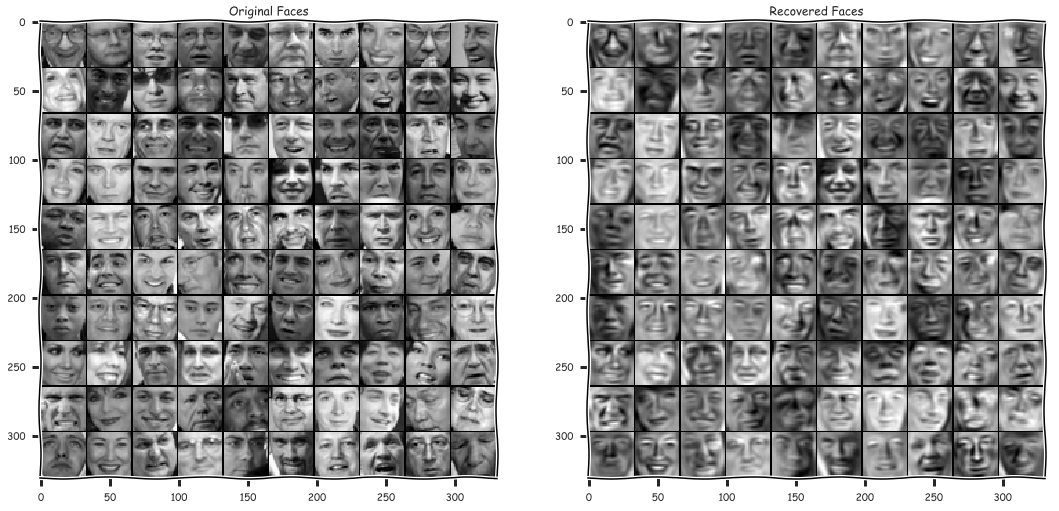

In [168]:
# Dimension reduction to face dataset
K = 100 # Reduce to 100 features
Z = projectData(X_norm, U, K)
print('The projected data has a size of {}'.format(Z.shape))

X_rec = recoverData(Z, U, K)

fig = plt.figure(figsize=(18, 9))

fig.add_subplot(121)
displayData(X[:100])
plt.title('Original Faces')
fig.add_subplot(122)
displayData(X_rec[:100])
plt.title('Recovered Faces')

In [169]:
# PCA for Visualization

# Load image
img = Image.open('bird_small.png')
img.load()
img = np.asarray(img, dtype=np.uint64)

# rescale so that images are in range 0-1
img = img / 255

X = np.reshape(img, (img.shape[0] * img.shape[1], 3))
K = 16
centroids_init = initCentroids(X, K)

centroids, idx = KMeans(X, centroids_init, max_iters=10, plot=False)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 16384 but corresponding boolean dimension is 1000


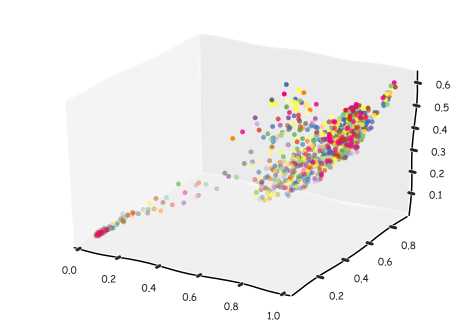

In [241]:
sel = idx[np.random.choice(len(idx), 1000, replace=False)]
plotData3D(X, sel, K)